In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
#import problem_unittests as tests
#import helper

%matplotlib inline

data_dir = '/content/drive/MyDrive/processed_celeba_small/'

In [3]:
!pip install torchvision

In [4]:
import os

data_dir = '/content/drive/MyDrive/processed_celeba_small/'

# Print list of files in the directory
print(os.listdir(data_dir))

['.DS_Store', 'celeba']


In [5]:
import torch
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

class DummyClassDataset(ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super(DummyClassDataset, self).__init__(root, transform=transform, target_transform=target_transform)

    def loader(self, path):
        return Image.open(path)

def get_dataloader(batch_size, image_size, data_dir='/content/drive/MyDrive/processed_celeba_small'):
    img_transforms = T.Compose([T.Resize(image_size),
                                T.ToTensor()])
    img_data = DummyClassDataset(data_dir, transform=img_transforms)

    img_loader = DataLoader(img_data, batch_size=batch_size, shuffle=True)

    return img_loader

batch_size = 64
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)

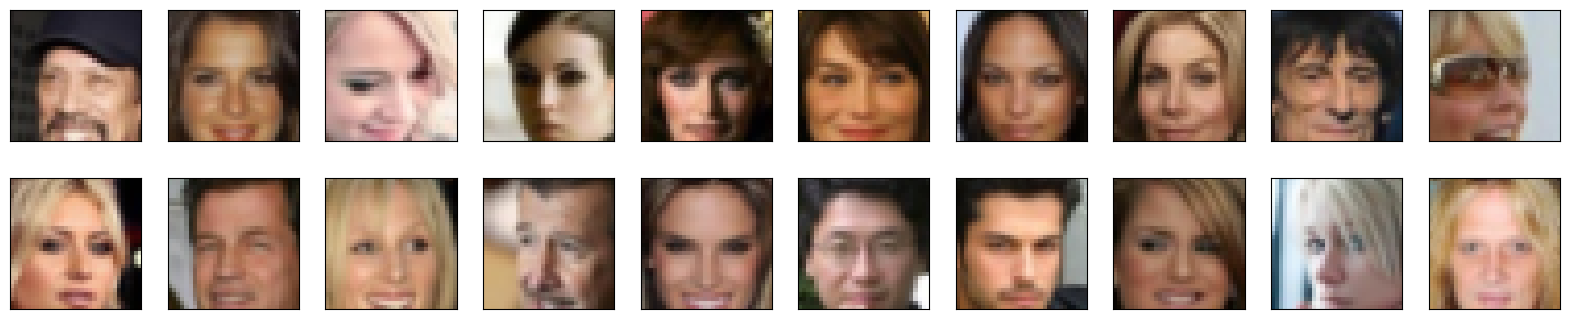

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    """
    Helper function for image visualization
    """
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Assuming celeba_train_loader is your DataLoader
dataiter = iter(celeba_train_loader)
images, _ = dataiter.__next__()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size = 20

# Convert plot_size to an integer
for idx in np.arange(int(plot_size)):
    ax = fig.add_subplot(2, plot_size//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

plt.show()

In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1.
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_, max_ = feature_range
    x = x * (max_ - min_) + min_
    return x

In [8]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.9529)


In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """
    Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels,
                           kernel_size, stride, padding, bias=False)

    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))

    # using Sequential container
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim # 32x32 input
        self.conv1 = conv(3, conv_dim, batch_norm=False) # first layer, no batch_norm # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2) # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4) # 4x4 out
        self.conv4 = conv(conv_dim*4, conv_dim*8) # 2x2 out
        self.fc = nn.Linear(conv_dim*8*2*2, 1) # final, fully-connected layer


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """

        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)

        out = out.view(-1, self.conv_dim*8*2*2) # flatten
        out = self.fc(out) # final output layer

        return out

In [11]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels,
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):

    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim

        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2)
        self.t_conv3 = deconv(conv_dim*2, conv_dim)
        self.t_conv4 = deconv(conv_dim, 3, batch_norm=False)


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior

        # fully-connected + reshape
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2)

        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))

        # last layer + tanh activation
        out = self.t_conv4(out)
        out = F.tanh(out)

        return out

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network
    """

    classname = m.__class__.__name__

    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)

In [14]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)

    return D, G

In [15]:
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

In [16]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [17]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''

    batch_size = D_out.size(0)

    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1

    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''

    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [18]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [19]:
path = '/content/drive/MyDrive/Project/'

In [20]:
import os

# Check if the directory exists, if not, create it
if not os.path.exists(path):
    os.makedirs(path)

In [25]:
def train(D, G, n_epochs, print_every=50):

    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
        print('true')

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        print('true')

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            print(f'Epoch [{epoch+1}/{n_epochs}]')

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            if train_on_gpu:
                real_images = real_images.cuda()

            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss

            g_optimizer.zero_grad()
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

        # save models
        torch.save(G.state_dict(), path+'G_checkpoint.pth')
        torch.save(D.state_dict(), path+'D_checkpoint.pth')

    # Save training generator samples
    with open(path+'train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # finally return losses
    return losses

train(D, G, n_epochs=100)

true
true
Epoch [1/100]
Epoch [    1/  100] | d_loss: 1.3628 | g_loss: 1.2811
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [2/100]
Epoch [    2/  100] | d_loss: 0.3749 | g_loss: 5.3378
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]


[(1.3628270626068115, 1.2811381816864014),
 (0.37487155199050903, 5.337820053100586),
 (0.4923456907272339, 4.641870975494385),
 (0.6185816526412964, 3.8231329917907715),
 (0.882038414478302, 4.9641804695129395),
 (0.6284287571907043, 2.5136446952819824),
 (0.8418983817100525, 1.7888851165771484),
 (0.7097890377044678, 3.4836490154266357),
 (0.6987264752388, 2.127734661102295),
 (0.9615533351898193, 3.469510793685913),
 (0.6973721385002136, 2.2773804664611816),
 (1.2185170650482178, 4.5693511962890625),
 (0.8791249990463257, 1.8648171424865723),
 (1.0384347438812256, 4.153352737426758),
 (1.2739245891571045, 1.3807432651519775),
 (0.6723921895027161, 2.5139904022216797),
 (0.7131949067115784, 3.758525848388672),
 (0.9921574592590332, 3.0539135932922363),
 (0.9587903022766113, 3.4963183403015137),
 (0.7503746747970581, 1.936596393585205),
 (0.884023904800415, 1.7935689687728882),
 (0.8055790662765503, 1.7190943956375122),
 (0.8142228126525879, 2.6819119453430176),
 (0.8883383274078369, 

In [31]:
import pickle as pkl
from torch.multiprocessing import Process, set_start_method

# Ensure that 'forkserver' is used as the start method to avoid issues with multiprocessing in Colab
try:
    set_start_method('forkserver')
except RuntimeError:
    pass

# Define your train function
def train_wrapper(D, G, n_epochs):
    losses = train(D, G, n_epochs=n_epochs)

    with open('/content/drive/MyDrive/Project/train_losses.pkl', 'wb') as f:
        pkl.dump(losses, f)

# Replace D and G with your actual objects
# D = ...
# G = ...

n_epochs = 100

# Start a new process to run the training
p = Process(target=train_wrapper, args=(D, G, n_epochs))

# Start the process
p.start()

# Wait for the process to finish
p.join()
train_wrapper(D, G, n_epochs)

true
true
Epoch [1/100]
Epoch [    1/  100] | d_loss: 0.5642 | g_loss: 3.4448
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [1/100]
Epoch [2/100]
Epoch [    2/  100] | d_loss: 1.3431 | g_loss: 7.0594
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]
Epoch [2/100]


In [32]:
import os
print(os.listdir(path))

['G_checkpoint.pth', 'D_checkpoint.pth', 'train_samples.pkl', 'train_losses.pkl']


In [33]:
G_state_dict = torch.load('/content/drive/MyDrive/Project/G_checkpoint.pth')
G.load_state_dict(G_state_dict)

D_state_dict = torch.load('/content/drive/MyDrive/Project/D_checkpoint.pth')
D.load_state_dict(D_state_dict)

with open('/content/drive/MyDrive/Project/train_samples.pkl', 'rb') as f:
        samples = pkl.load(file=f)

with open('/content/drive/MyDrive/Project/train_losses.pkl', 'rb') as f:
        losses = pkl.load(file=f)

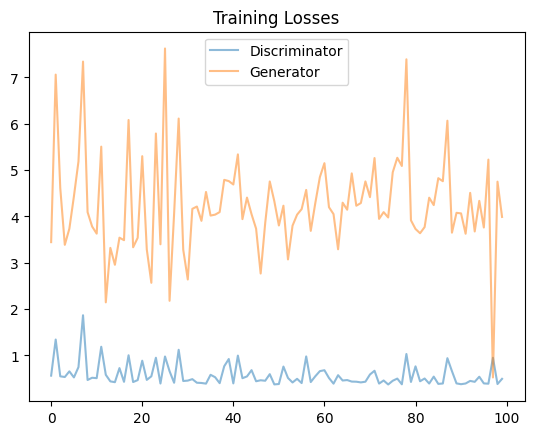

In [34]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [35]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [36]:
with open('/content/drive/MyDrive/Project/train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

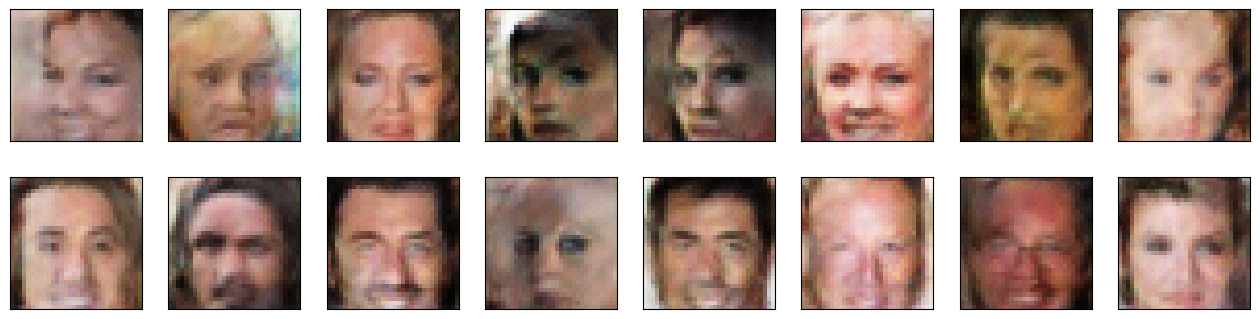

In [37]:
_ = view_samples(-1, samples)